# Data Analysis Project - M2 TIW

> Note: For detailed description of the project and the dataset, please take a look at the README file

- **Dataset:** [Heart Attack Analysis & Prediction](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset)
- **Student name:** Eldar Kasmamytov
- **Student number:** p1712650

---

**Table of contents**

1. [Pre-requisites](#pre-requisites)  
    1.1 [Import dependencies](#import-dependencies)  
    1.2 [Import the dataset](#import-the-dataset)  
    1.3 [Set the constants](#set-the-constants)  

2. [Description](#description)  
    2.1 [Blank values](#blank-values)  
    2.2 [Attributes' types](#attributes-types)  

3. [Exploration](#exploration)  
    3.1&nbsp;&nbsp; [Correlation Matrix](#correlation-matrix)  
    3.2&nbsp;&nbsp; [Target attribute Heart attack chance](#target-attribute-heart-attack-chance)  
    3.3&nbsp;&nbsp; [Sex distribution](#sex-distribution)  
    3.4&nbsp;&nbsp; [Age distribution](#age-distribution)  
    3.5&nbsp;&nbsp; [Chest Pain distribution](#chest-pain-distribution)  
    3.6&nbsp;&nbsp; [Resting ECG distribution](#resting-ecg-distribution)  
    3.7&nbsp;&nbsp; [Slope of the ST-Segment of ECG distribution](#slope-of-the-st-segment-of-ecg-distribution)  
    3.8&nbsp;&nbsp; [Thalassemia distribution](#thalassemia-distribution)  
    3.9&nbsp;&nbsp; [Blood Sugar level distribution](#blood-sugar-level-distribution)  
    3.10 [Angina (exercise induced) distribution](#angina-exercise-induced-distribution)  
    3.11 [Resting Blood Pressure Rates](#resting-blood-pressure-rates)  
    3.12 [Cholestoral](#cholestoral)  
    3.13 [Total Maxium Heart Rate Achieved (thalachh)](#total-maxium-heart-rate-achieved-thalachh)  

4. [Prediction](#prediction)  
    4.1 [Pre-processing](#pre-processing)  
    &nbsp;&nbsp;&nbsp;&nbsp;4.1.1 [Split the dataset into training and testing sets](#split-the-dataset-into-training-and-testing-sets)  
    &nbsp;&nbsp;&nbsp;&nbsp;4.1.2 [Upsampling / Balancing](#upsampling--balancing)  
    &nbsp;&nbsp;&nbsp;&nbsp;4.1.3 [Transformation Pipeline](#transformation-pipeline)  
    4.2 [Naive Approach](#naive-approach)  
    4.3 [Model Selection](#model-selection)  
    &nbsp;&nbsp;&nbsp;&nbsp;4.3.1 [Try different classifiers and compare the results](#try-different-classifiers-and-compare-the-results)  
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4.3.1.1 [Results](#results)  
    4.4 [Hyperparameter optimization / tuning](#hyperparameter-optimization--tuning)  
    4.5 [Model Evaluation](#model-evaluation)  

---

<a name="pre-requisites"></a>
## Pre-requisites

<a name="import-dependencies"></a>
### Import dependencies

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import shapiro
from scipy.stats import pearsonr
from functools import reduce

# For Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# For Model Selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict, StratifiedKFold

# For Evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

# Custom
from attributes import Sex, ChestPain, ECG, Slope, HeartAttack, Thalassemia

<a name="import-the-dataset"></a>
### Import the dataset

In [2]:
df = pd.read_csv('dataset/heart.csv')
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


<a name="set-the-constants"></a>
### Set the constants

In [3]:
SEED = 42

TARGET = 'output'
FEATURES = df.columns.drop(TARGET)

CONTINUOUS = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
CATEGORICAL = df[FEATURES].columns.drop(CONTINUOUS)

df_likely = df[df[TARGET] == HeartAttack.Likely.value]
df_notlikely = df[df[TARGET] == HeartAttack.NotLikely.value]

---

<a name="description"></a>
## Description

<a name="blank-values"></a>
### Blank values
There is no **`null`** values in the dataset.

In [4]:
df.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

Nevertheless, one of the attributes (`thall`, Thalassemia) has a value (`0`) representing **`null`** in the original dataset.  

-> In the future, if this attribute is procesed, these null values should be removed from the DataFrame in order to avoid bias.

In [5]:
print('Unique values: ', df.thall.unique())
print('Count of value \'0\': ', df.thall.loc[df.thall == 0].count())

Unique values:  [1 2 3 0]
Count of value '0':  2


<a name="attributes-types"></a>
### Attributes' types

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


Every variable has a numeric value, that helps to easily handle them, apply tests.

> Note: Some of the variables actually represent an enumeration and are mapped to a certain value (see the full description of attributes in README)

<a id="exploration"></a>
## Exploration

<a name="correlation-matrix"></a>
### Correlation Matrix

In order to illustrate the global correlation between the variables, let's plot a **correlation matrix**:

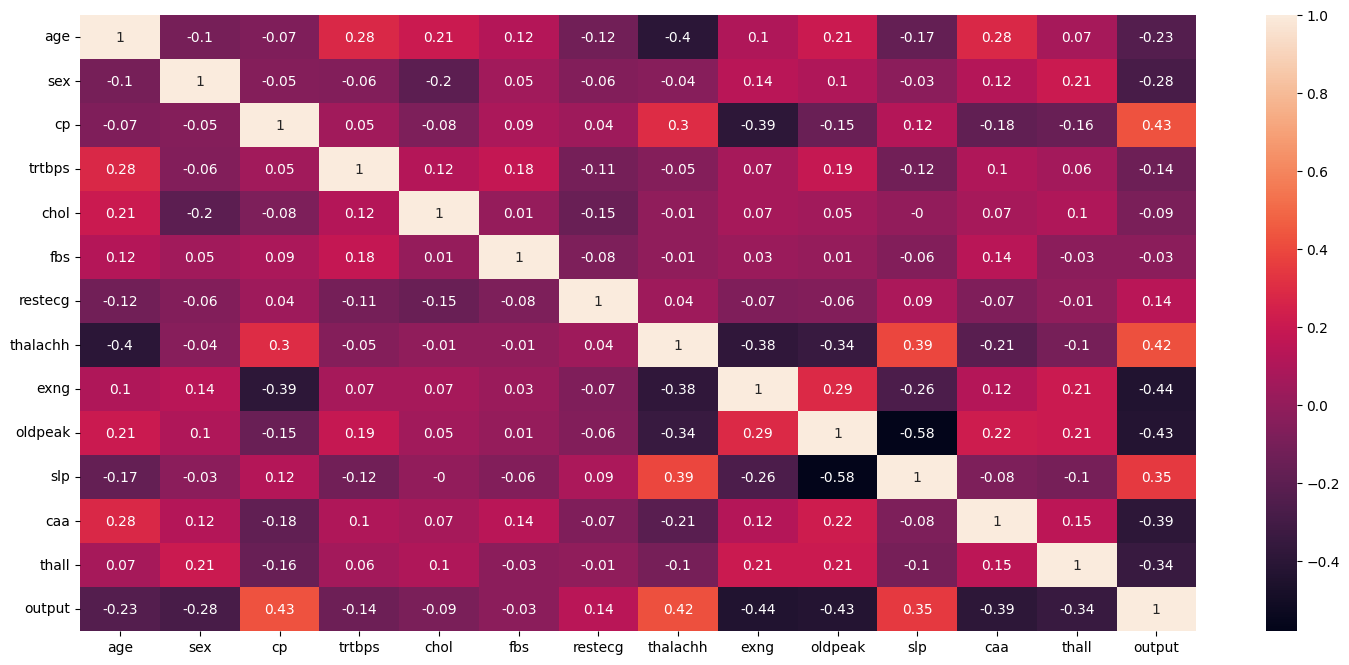

In [7]:
plt.figure(figsize=(18, 8))
corr_mtrx = sns.heatmap(df.corr().round(2), annot=True)

In this way, we can **clearly see** and **quickly identify** the most/least correlated attributes.

For instance, for the **target** attribute the **most positively** correlated attributes are:
- `cp` - Chest Pain type
- `thalachh` - Total Maxium Heart Rate Achieved
- `slp` - The slope of the peak exercise ST segment of ECG

And the **most negatively** correlated attributes are:
- `exng` - Exercise induced angina (Predicate)
- `oldpeak` - ST depression induced by exercise relative to rest (Real number)
- `caa` - Number of major vessels (0-3)
- `thall` - Thalassemia

> Note: Even though, zeros in the correlation matrix tend to mean absence of correlation, it is not always the case (the dinosaur example). Thus, we would need to use other metrics to identify them..

<a name="target-attribute-heart-attack-chance"></a>
### Target attribute `Heart attack chance`

Distribution of the Target attribute: 
 1    165
0    138
Name: output, dtype: int64


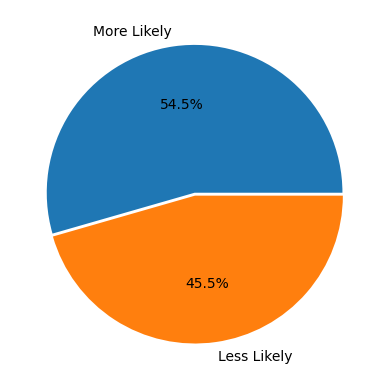

In [8]:
target_value_counts = df[TARGET].value_counts()
print('Distribution of the Target attribute:', '\n', target_value_counts)

plt.pie(target_value_counts, labels=['More Likely', 'Less Likely'], explode=[0.01, 0.01], autopct="%1.1f%%")
plt.show()

<a name="sex-distribution"></a>
### `Sex` distribution

Sex distribution (Total): 
 1    207
0     96
Name: sex, dtype: int64
Sex distribution (MORE chance of heart attack): 
 1    93
0    72
Name: sex, dtype: int64
Sex distribution (LESS chance of heart attack): 
 1    114
0     24
Name: sex, dtype: int64


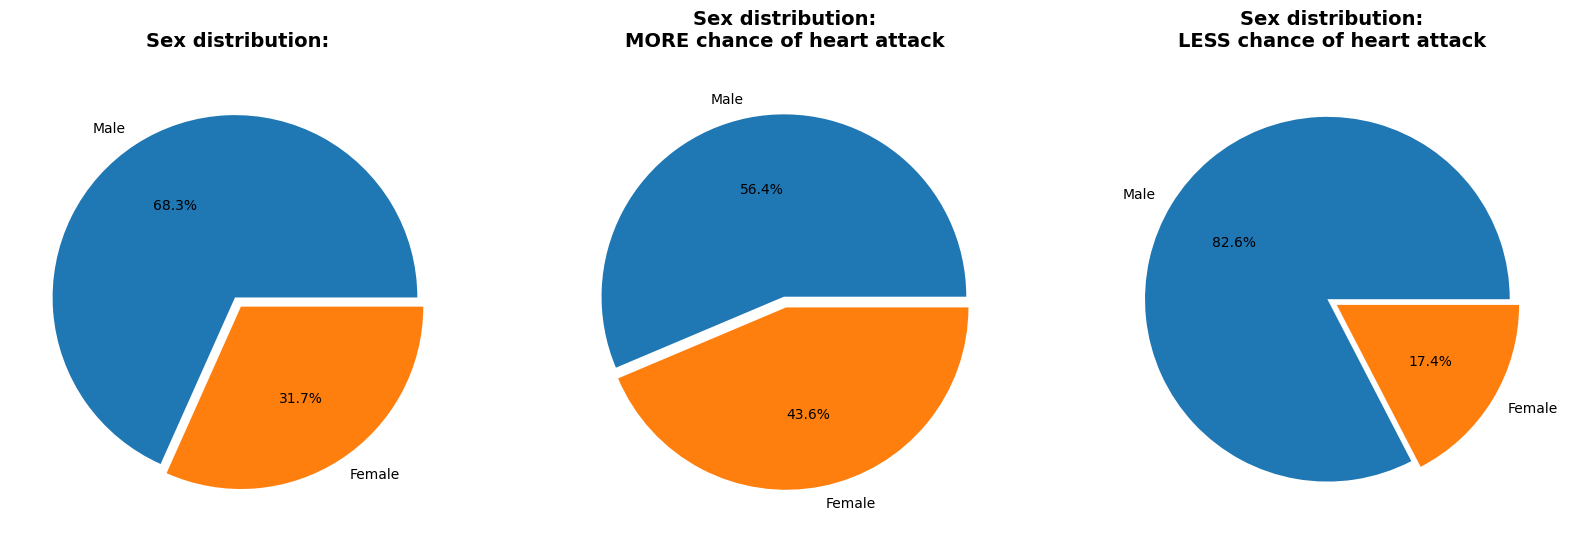

In [9]:
# Display count
print('Sex distribution (Total):', '\n', df.sex.value_counts())
print('Sex distribution (MORE chance of heart attack):', '\n', df_likely.sex.value_counts())
print('Sex distribution (LESS chance of heart attack):', '\n', df_notlikely.sex.value_counts())

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
labels = ['Male', 'Female']
explode = [0.03, 0.03]

# Pie Charts
ax[0].pie(df.sex.value_counts(), explode=explode, labels=labels, autopct="%1.1f%%")
ax[1].pie(df_likely.sex.value_counts(), explode=explode, labels=labels, autopct="%1.1f%%")
ax[2].pie(df_notlikely.sex.value_counts(), explode=explode, labels=labels, autopct="%1.1f%%")

# Charts' Titles
textOpts = {
    'fontsize': 14,
    'fontweight': 'bold',
    'horizontalalignment': 'center'
}
textPosX = 0; textPosY = 1.4
ax[0].text(textPosX, textPosY, 'Sex distribution:', textOpts)
ax[1].text(textPosX, textPosY, 'Sex distribution:\nMORE chance of heart attack', textOpts)
ax[2].text(textPosX, textPosY, 'Sex distribution:\nLESS chance of heart attack', textOpts)

plt.show()

<a name="age-distribution"></a>
### `Age` distribution

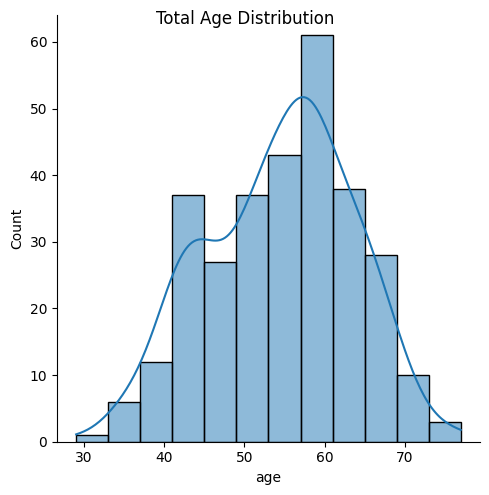

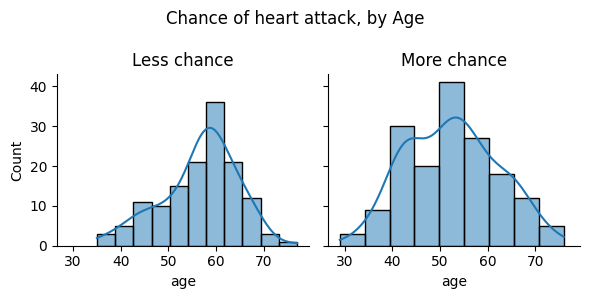

In [10]:
# Total Age distribution
facetGrid = sns.displot(df.age, kde=True)
facetGrid.figure.suptitle("Total Age Distribution")

facetGrid2 = sns.FacetGrid(df, col=TARGET)

# mapping of target attribute's values
facetGrid2.axes[0][HeartAttack.NotLikely.value].set_title("Less chance")
facetGrid2.axes[0][HeartAttack.Likely.value].set_title("More chance")

facetGrid2.figure.suptitle("Chance of heart attack, by Age") # Set global title

facetGrid2.map(sns.histplot, "age", kde=True)

#### Statistical tests (Shapiro):

In [11]:
print('Shapiro Test for Total Age Distribution:', '\n', shapiro(df.age), '\n')

print('Shapiro Test for "not likely":', '\n', shapiro(df_notlikely.age))
print('Shapiro Test for "likely":', '\n', shapiro(df_likely.age))

df_notlikely_subset = df_notlikely.age.loc[(df_notlikely.age > 50) & (df_notlikely.age < 70)]
print('Shapiro Test for "not likely" (50-70 years):', '\n', shapiro(df_notlikely_subset))

Shapiro Test for Total Age Distribution: 
 ShapiroResult(statistic=0.9863712787628174, pvalue=0.005800595041364431) 

Shapiro Test for "not likely": 
 ShapiroResult(statistic=0.9686175584793091, pvalue=0.002868662355467677)
Shapiro Test for "likely": 
 ShapiroResult(statistic=0.9867705702781677, pvalue=0.12113280594348907)
Shapiro Test for "not likely" (50-70 years): 
 ShapiroResult(statistic=0.9782580733299255, pvalue=0.08194907754659653)


Après avoir executé les tests statistiques de Shapiro:

- **`Likely (by age):`** \
    Etant donné que **pvalue > 0.05**, on peut dire que ces observations suivent la distribution normale.

- **`Not likely (by age):`** \
    Par contre, ici, **pvalue < 0.05**, donc ce n'est pas une distribution normale.
    
    > Note: Cependant, on peut voir sur le graphique qu'une partie des observations suit la loi normale (par exemple, *de 50 à 70 ans*), ce qui est vérifié par le test statistique de Shapiro.

<a name="chest-pain-distribution"></a>
### `Chest Pain` distribution

Chest Pain distribution (Total): 
 0    143
2     87
1     50
3     23
Name: cp, dtype: int64
Chest Pain distribution (MORE chance of heart attack): 
 2    69
1    41
0    39
3    16
Name: cp, dtype: int64
Chest Pain distribution (LESS chance of heart attack): 
 0    104
2     18
1      9
3      7
Name: cp, dtype: int64


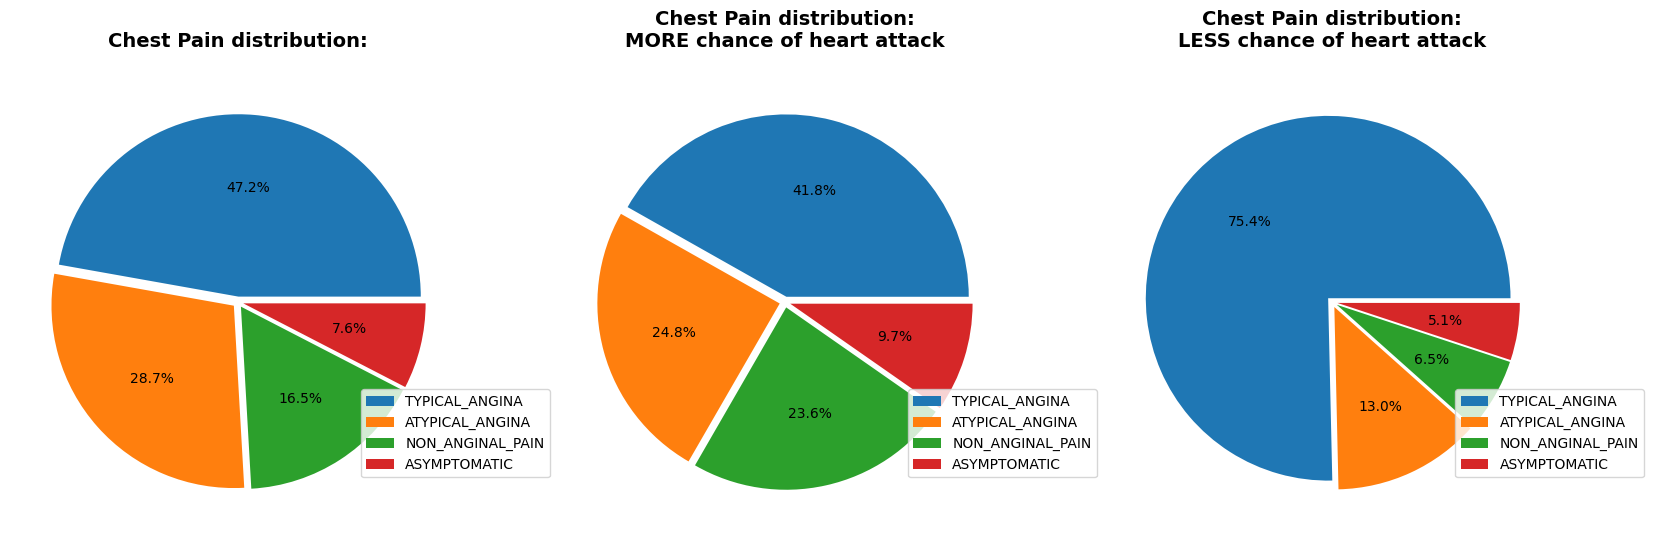

In [12]:
# Display count
print('Chest Pain distribution (Total):', '\n', df.cp.value_counts())
print('Chest Pain distribution (MORE chance of heart attack):', '\n', df_likely.cp.value_counts())
print('Chest Pain distribution (LESS chance of heart attack):', '\n', df_notlikely.cp.value_counts())

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
cp_unique_count = len(df.cp.unique())
explode = [0.03] * cp_unique_count

# Sort items in pandas.Series by index
sorted_items_cp1 = df.cp.value_counts().sort_index()
sorted_items_cp2 = df_likely.cp.value_counts().sort_index()
sorted_items_cp3 = df_notlikely.cp.value_counts().sort_index()

# Get sorted Titles
labels_cp = reduce(lambda list, item: list + [item.name], sorted(ChestPain, key=lambda x: x.value), [])

# Pie Charts
ax[0].pie(df.cp.value_counts(), explode=explode, autopct="%1.1f%%")
ax[0].legend(labels=labels_cp, loc='lower right', bbox_to_anchor=(1.2, 0.1))
ax[1].pie(df_likely.cp.value_counts(), explode=explode, autopct="%1.1f%%")
ax[1].legend(labels=labels_cp, loc='lower right', bbox_to_anchor=(1.2, 0.1))
ax[2].pie(df_notlikely.cp.value_counts(), explode=explode, autopct="%1.1f%%")
ax[2].legend(labels=labels_cp, loc='lower right', bbox_to_anchor=(1.2, 0.1))

# Charts' Titles
textOpts = {
    'fontsize': 14,
    'fontweight': 'bold',
    'horizontalalignment': 'center'
}
textPosX = 0; textPosY = 1.4
ax[0].text(textPosX, textPosY, 'Chest Pain distribution:', textOpts)
ax[1].text(textPosX, textPosY, 'Chest Pain distribution:\nMORE chance of heart attack', textOpts)
ax[2].text(textPosX, textPosY, 'Chest Pain distribution:\nLESS chance of heart attack', textOpts)

plt.show()

#### Pearson Correlation Coefficient

In [13]:
pearsonr(df.cp, df[TARGET])

PearsonRResult(statistic=0.43379826150689454, pvalue=2.469712108922564e-15)

The statistic test shows that there is a rather **positive correlation** (*~ 0.4338*), that **aligns** with the `cp` distribution illustrated above.

- This means, the higher the `cp` index (*), the higher the chance of heart attack.

> (*) These `cp` indexes are mapped to a **certain chest pain type**, starting from zero (0 being the lightest type Typical_Angina, see the full description of attributes in README)

<a name="resting-ecg-distribution"></a>
### `Resting ECG` distribution

ECG distribution (Total): 
 1    152
0    147
2      4
Name: restecg, dtype: int64
ECG distribution (MORE chance of heart attack) 
 1    96
0    68
2     1
Name: restecg, dtype: int64
ECG distribution (LESS chance of heart attack) 
 0    79
1    56
2     3
Name: restecg, dtype: int64


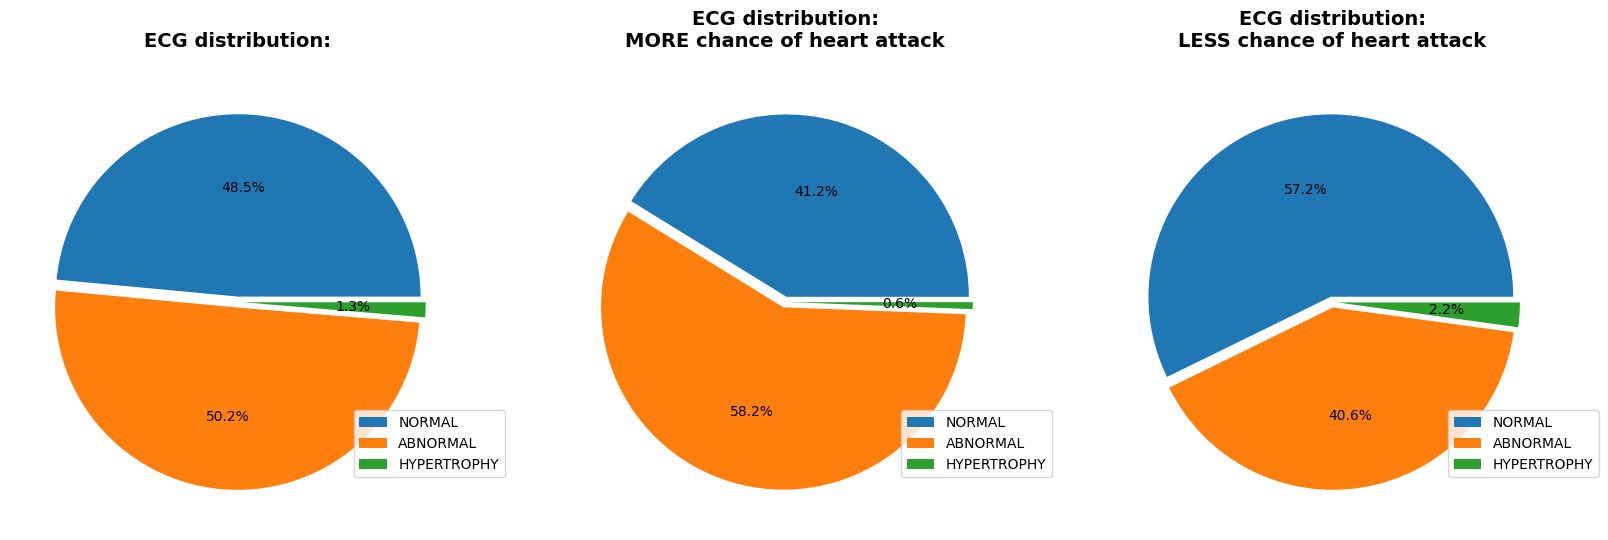

In [14]:
# Display count
print('ECG distribution (Total):', '\n', df.restecg.value_counts())
print('ECG distribution (MORE chance of heart attack)', '\n', df_likely.restecg.value_counts())
print('ECG distribution (LESS chance of heart attack)', '\n', df_notlikely.restecg.value_counts())

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
ecg_unique_count = len(df.restecg.unique())
explode = [0.03] * ecg_unique_count

# Sort items in pandas.Series by index
sorted_items_ecg1 = df.restecg.value_counts().sort_index()
sorted_items_ecg2 = df_likely.restecg.value_counts().sort_index()
sorted_items_ecg3 = df_notlikely.restecg.value_counts().sort_index()

# Get sorted Titles
labels_ecg = reduce(lambda list, item: list + [item.name], sorted(ECG, key=lambda x: x.value), [])

# Pie Charts
ax[0].pie(sorted_items_ecg1, explode=explode, autopct="%1.1f%%")
ax[0].legend(labels=labels_ecg, loc='lower right', bbox_to_anchor=(1.1, 0.1))
ax[1].pie(sorted_items_ecg2, explode=explode, autopct="%1.1f%%")
ax[1].legend(labels=labels_ecg, loc='lower right', bbox_to_anchor=(1.1, 0.1))
ax[2].pie(sorted_items_ecg3, explode=explode, autopct="%1.1f%%")
ax[2].legend(labels=labels_ecg, loc='lower right', bbox_to_anchor=(1.1, 0.1))

# Charts' Titles
textOpts = {
    'fontsize': 14,
    'fontweight': 'bold',
    'horizontalalignment': 'center'
}
textPosX = 0; textPosY = 1.4
ax[0].text(textPosX, textPosY, 'ECG distribution:', textOpts)
ax[1].text(textPosX, textPosY, 'ECG distribution:\nMORE chance of heart attack', textOpts)
ax[2].text(textPosX, textPosY, 'ECG distribution:\nLESS chance of heart attack', textOpts)

plt.show()

There is a bit **more chance of heart attack** in the case of an **abnormal ECG**, and in contrast, **less chance of heart attack** if **ECG is normal**. This can clearly be seen on the pie charts above.

In order to confirm that, let's perform a **statistic test**.

#### Pearson Correlation Coefficient

In [15]:
pearsonr(df.restecg, df[TARGET])

PearsonRResult(statistic=0.13722950287377328, pvalue=0.016839897060127035)

There is a slightly **positive correlation** (*of ~ 0.137*), that **confirms** the observations above.

<a name="slope-of-the-st-segment-of-ecg-distribution"></a>
### `Slope of the ST-Segment of ECG` distribution

Slope of the ST-Segment of ECG (Total): 
 2    142
1    140
0     21
Name: slp, dtype: int64
Slope of the ST-Segment of ECG (MORE chance of heart attack) 
 2    107
1     49
0      9
Name: slp, dtype: int64
Slope of the ST-Segment of ECG (LESS chance of heart attack) 
 1    91
2    35
0    12
Name: slp, dtype: int64


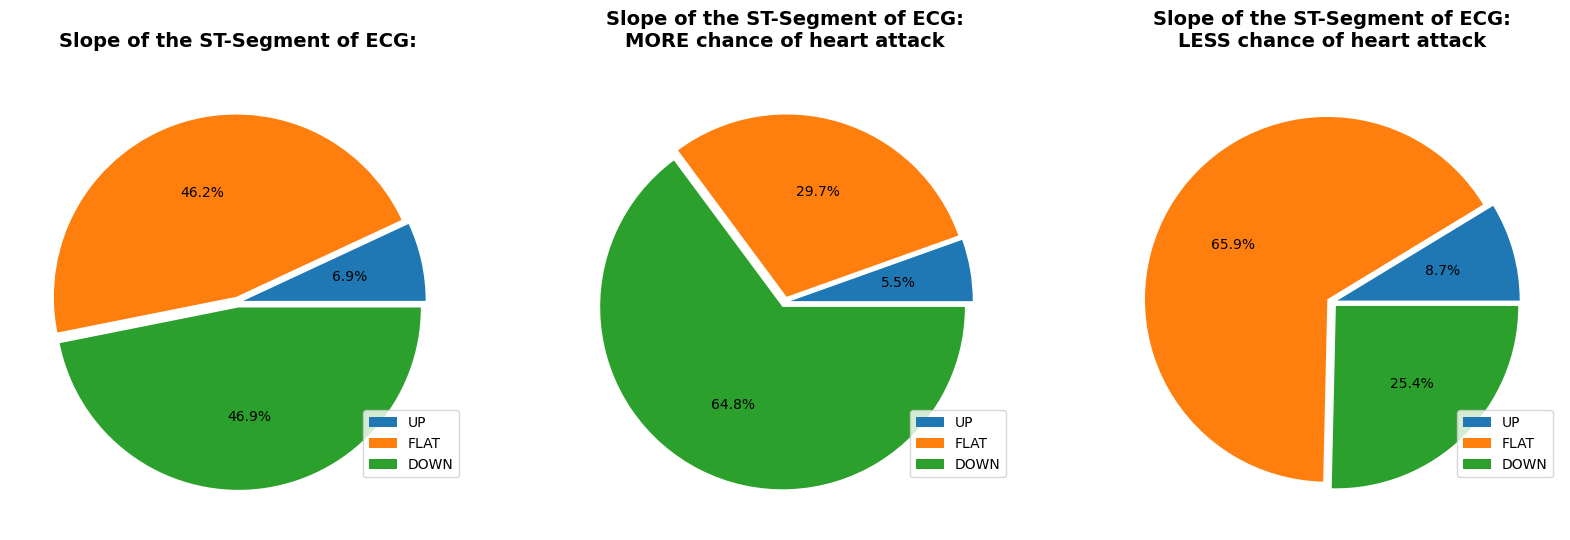

In [16]:
# Display count
print('Slope of the ST-Segment of ECG (Total):', '\n', df.slp.value_counts())
print('Slope of the ST-Segment of ECG (MORE chance of heart attack)', '\n', df_likely.slp.value_counts())
print('Slope of the ST-Segment of ECG (LESS chance of heart attack)', '\n', df_notlikely.slp.value_counts())

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
slp_unique_count = len(df.slp.unique())
explode = [0.03] * slp_unique_count

# Sort items in pandas.Series by index
sorted_items_slp1 = df.slp.value_counts().sort_index()
sorted_items_slp2 = df_likely.slp.value_counts().sort_index()
sorted_items_slp3 = df_notlikely.slp.value_counts().sort_index()

# Get sorted Titles
labels_slp = reduce(lambda list, item: list + [item.name], sorted(Slope, key=lambda x: x.value), [])

# Pie Charts
ax[0].pie(sorted_items_slp1, explode=explode, autopct="%1.1f%%")
ax[0].legend(labels=labels_slp, loc='lower right', bbox_to_anchor=(1, 0.1))
ax[1].pie(sorted_items_slp2, explode=explode, autopct="%1.1f%%")
ax[1].legend(labels=labels_slp, loc='lower right', bbox_to_anchor=(1, 0.1))
ax[2].pie(sorted_items_slp3, explode=explode, autopct="%1.1f%%")
ax[2].legend(labels=labels_slp, loc='lower right', bbox_to_anchor=(1, 0.1))

# Charts' Titles
textOpts = {
    'fontsize': 14,
    'fontweight': 'bold',
    'horizontalalignment': 'center'
}
textPosX = 0; textPosY = 1.4
ax[0].text(textPosX, textPosY, 'Slope of the ST-Segment of ECG:', textOpts)
ax[1].text(textPosX, textPosY, 'Slope of the ST-Segment of ECG:\nMORE chance of heart attack', textOpts)
ax[2].text(textPosX, textPosY, 'Slope of the ST-Segment of ECG:\nLESS chance of heart attack', textOpts)

plt.show()

This attribute has a rather strong positive correlation with the target attribute. This can be verified with the value in the correlation matrix above.

<a name="thalassemia-distribution"></a>
### `Thalassemia` distribution

Thalassemia Distribution (Total): 
 2    166
3    117
1     18
0      2
Name: thall, dtype: int64
Thalassemia Distribution (MORE chance of heart attack) 
 2    130
3     28
1      6
0      1
Name: thall, dtype: int64
Thalassemia Distribution (LESS chance of heart attack) 
 3    89
2    36
1    12
0     1
Name: thall, dtype: int64


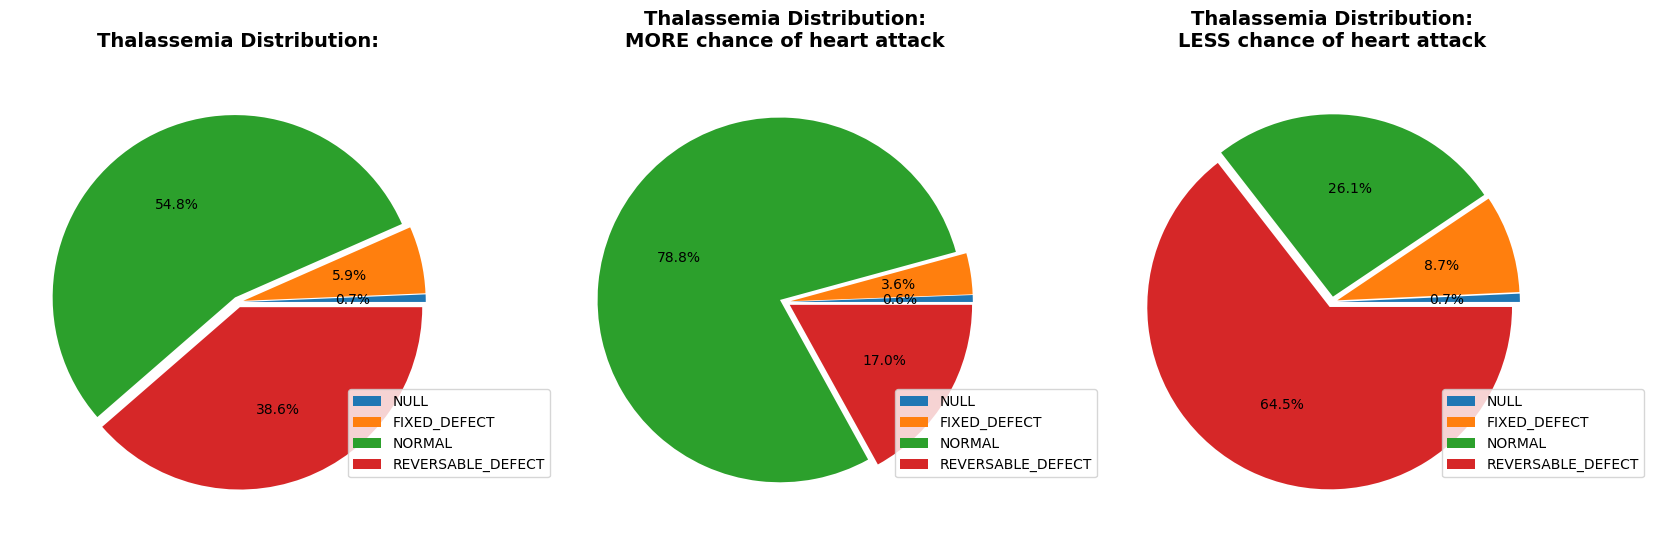

In [17]:
# Display count
print('Thalassemia Distribution (Total):', '\n', df.thall.value_counts())
print('Thalassemia Distribution (MORE chance of heart attack)', '\n', df_likely.thall.value_counts())
print('Thalassemia Distribution (LESS chance of heart attack)', '\n', df_notlikely.thall.value_counts())

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
thall_unique_count = len(df.thall.unique())
explode = [0.03] * thall_unique_count

# Sort items in pandas.Series by index
sorted_items_thall1 = df.thall.value_counts().sort_index()
sorted_items_thall2 = df_likely.thall.value_counts().sort_index()
sorted_items_thall3 = df_notlikely.thall.value_counts().sort_index()

# Get sorted Titles
labels_thall = reduce(lambda list, item: list + [item.name], sorted(Thalassemia, key=lambda x: x.value), [])

# Pie Charts
ax[0].pie(sorted_items_thall1, explode=explode, autopct="%1.1f%%")
ax[0].legend(labels=labels_thall, loc='lower right', bbox_to_anchor=(1.2, 0.1))
ax[1].pie(sorted_items_thall2, explode=explode, autopct="%1.1f%%")
ax[1].legend(labels=labels_thall, loc='lower right', bbox_to_anchor=(1.2, 0.1))
ax[2].pie(sorted_items_thall3, explode=explode, autopct="%1.1f%%")
ax[2].legend(labels=labels_thall, loc='lower right', bbox_to_anchor=(1.2, 0.1))

# Charts' Titles
textOpts = {
    'fontsize': 14,
    'fontweight': 'bold',
    'horizontalalignment': 'center'
}
textPosX = 0; textPosY = 1.4
ax[0].text(textPosX, textPosY, 'Thalassemia Distribution:', textOpts)
ax[1].text(textPosX, textPosY, 'Thalassemia Distribution:\nMORE chance of heart attack', textOpts)
ax[2].text(textPosX, textPosY, 'Thalassemia Distribution:\nLESS chance of heart attack', textOpts)

plt.show()

This attribute has a rather strong positive correlation with the target attribute. This can be verified with the value in the correlation matrix above.

<a name="blood-sugar-level-distribution"></a>
### `Blood Sugar level` distribution

Fasting Blood Sugar (FBS) distribution (Total): 
 0    258
1     45
Name: fbs, dtype: int64
Fasting Blood Sugar (FBS) distribution (MORE chance of heart attack): 
 0    142
1     23
Name: fbs, dtype: int64
Fasting Blood Sugar (FBS) distribution (LESS chance of heart attack): 
 0    116
1     22
Name: fbs, dtype: int64


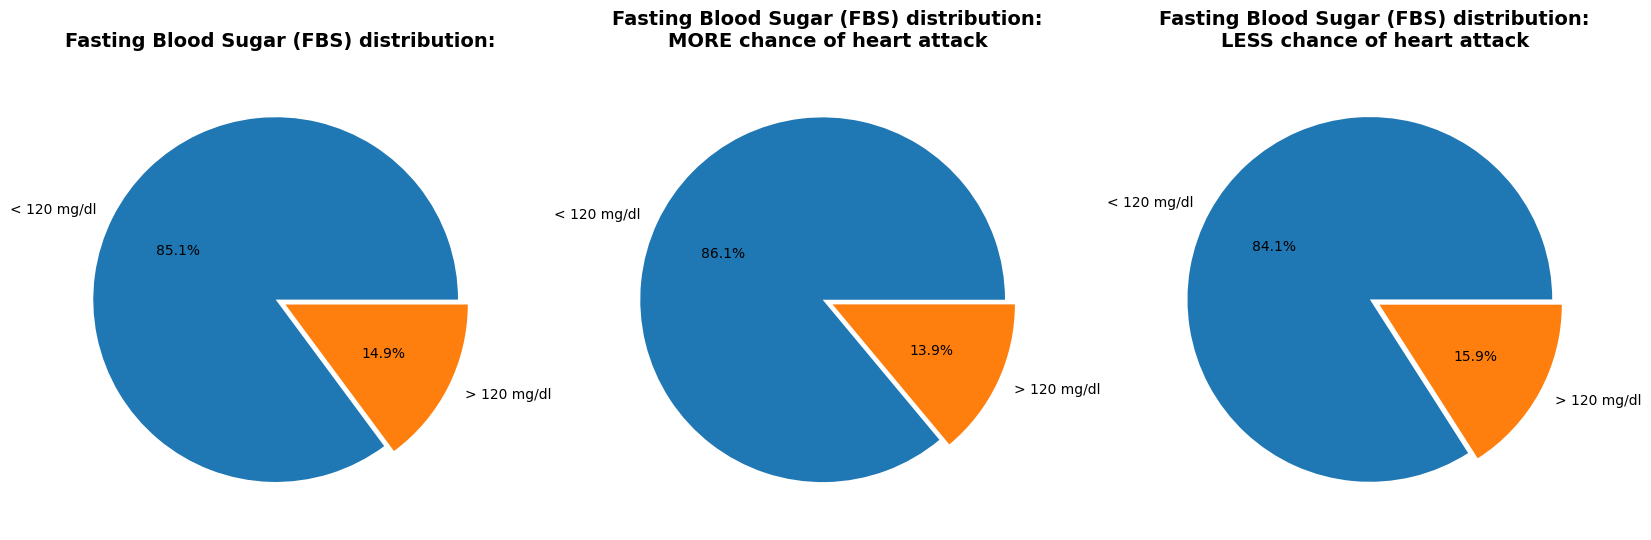

In [18]:
# Display count
print('Fasting Blood Sugar (FBS) distribution (Total):', '\n', df.fbs.value_counts())
print('Fasting Blood Sugar (FBS) distribution (MORE chance of heart attack):', '\n', df_likely.fbs.value_counts())
print('Fasting Blood Sugar (FBS) distribution (LESS chance of heart attack):', '\n', df_notlikely.fbs.value_counts())

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
fbs_unique_count = len(df.fbs.unique())
explode = [0.03] * fbs_unique_count
labels = ["< 120 mg/dl", "> 120 mg/dl"] # 0 (False), 1 (True)

# Sort items in pandas.Series by index
sorted_items_fbs1 = df.fbs.value_counts().sort_index()
sorted_items_fbs2 = df_likely.fbs.value_counts().sort_index()
sorted_items_fbs3 = df_notlikely.fbs.value_counts().sort_index()

# Pie Charts
ax[0].pie(sorted_items_fbs1, explode=explode, labels=labels, autopct="%1.1f%%")
ax[1].pie(sorted_items_fbs2, explode=explode, labels=labels, autopct="%1.1f%%")
ax[2].pie(sorted_items_fbs3, explode=explode, labels=labels, autopct="%1.1f%%")

# Charts' Titles
textOpts = {
    'fontsize': 14,
    'fontweight': 'bold',
    'horizontalalignment': 'center'
}
textPosX = 0; textPosY = 1.4
ax[0].text(textPosX, textPosY, 'Fasting Blood Sugar (FBS) distribution:', textOpts)
ax[1].text(textPosX, textPosY, 'Fasting Blood Sugar (FBS) distribution:\nMORE chance of heart attack', textOpts)
ax[2].text(textPosX, textPosY, 'Fasting Blood Sugar (FBS) distribution:\nLESS chance of heart attack', textOpts)

plt.show()

<a name="angina-exercise-induced-distribution"></a>
### `Angina (exercise induced)` distribution

Exercise induced angina distribution (Total): 
 0    204
1     99
Name: exng, dtype: int64
Exercise induced angina distribution (MORE chance of heart attack): 
 0    142
1     23
Name: exng, dtype: int64
Exercise induced angina distribution (LESS chance of heart attack): 
 1    76
0    62
Name: exng, dtype: int64


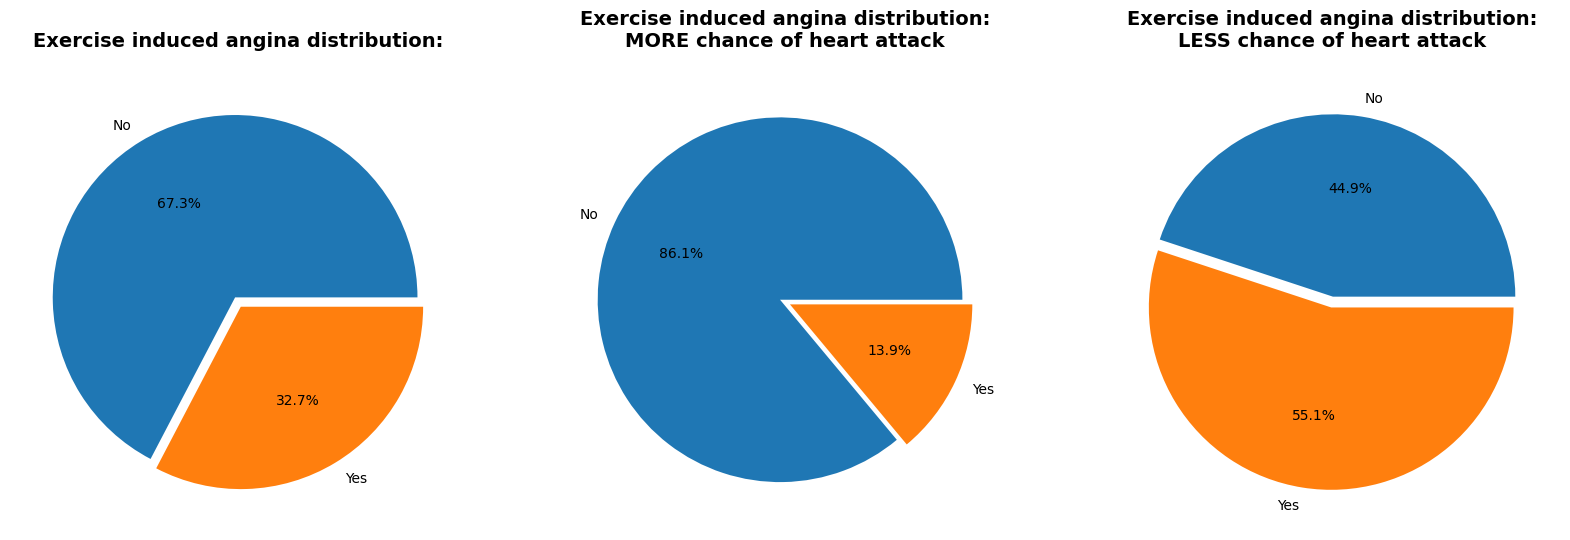

In [19]:
# Display count
print('Exercise induced angina distribution (Total):', '\n', df.exng.value_counts())
print('Exercise induced angina distribution (MORE chance of heart attack):', '\n', df_likely.exng.value_counts())
print('Exercise induced angina distribution (LESS chance of heart attack):', '\n', df_notlikely.exng.value_counts())

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
exng_unique_count = len(df.exng.unique())
explode = [0.03] * exng_unique_count
labels = ["No", "Yes"] # 0 (False), 1 (True)

# Sort items in pandas.Series by index
sorted_items_exng1 = df.exng.value_counts().sort_index()
sorted_items_exng2 = df_likely.exng.value_counts().sort_index()
sorted_items_exng3 = df_notlikely.exng.value_counts().sort_index()

# Pie Charts
ax[0].pie(sorted_items_exng1, explode=explode, labels=labels, autopct="%1.1f%%")
ax[1].pie(sorted_items_exng2, explode=explode, labels=labels, autopct="%1.1f%%")
ax[2].pie(sorted_items_exng3, explode=explode, labels=labels, autopct="%1.1f%%")

# Charts' Titles
textOpts = {
    'fontsize': 14,
    'fontweight': 'bold',
    'horizontalalignment': 'center'
}
textPosX = 0; textPosY = 1.4
ax[0].text(textPosX, textPosY, 'Exercise induced angina distribution:', textOpts)
ax[1].text(textPosX, textPosY, 'Exercise induced angina distribution:\nMORE chance of heart attack', textOpts)
ax[2].text(textPosX, textPosY, 'Exercise induced angina distribution:\nLESS chance of heart attack', textOpts)

plt.show()

<a name="resting-blood-pressure-rates"></a>
### Resting Blood Pressure Rates

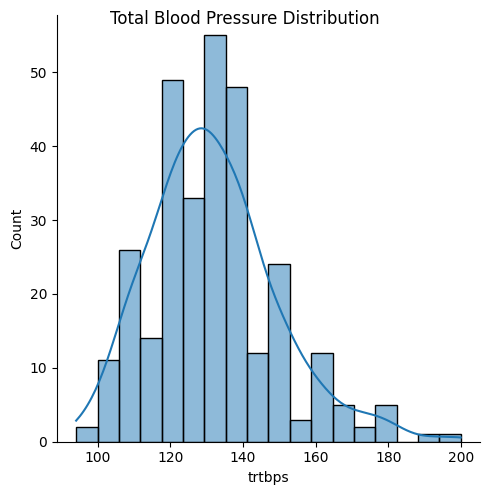

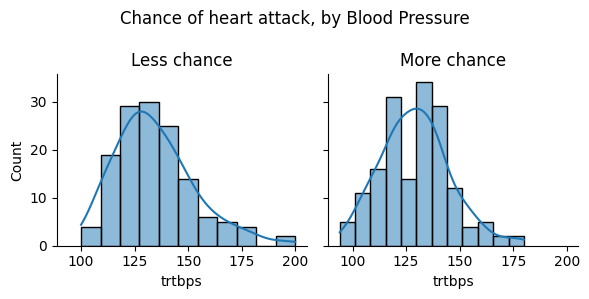

In [20]:
# Total Blood Pressure distribution
g = sns.displot(df.trtbps, kde=True)
g.figure.suptitle("Total Blood Pressure Distribution")

g2 = sns.FacetGrid(df, col=TARGET)

# mapping of target attribute's values
axes = g2.axes.flatten()
axes[HeartAttack.NotLikely.value].set_title("Less chance")
axes[HeartAttack.Likely.value].set_title("More chance")

g2.figure.suptitle("Chance of heart attack, by Blood Pressure") # Set global title

g2.map(sns.histplot, "trtbps", kde=True)

<a name="cholestoral"></a>
### Cholestoral

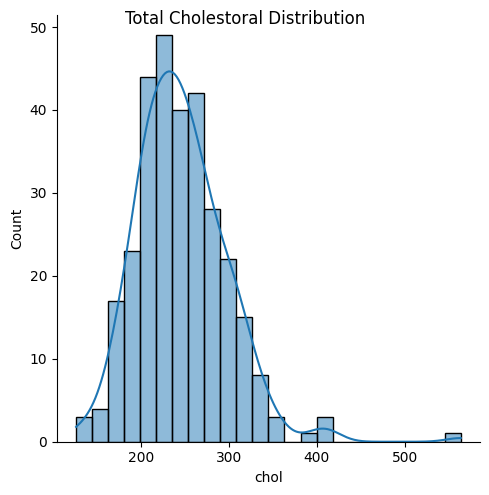

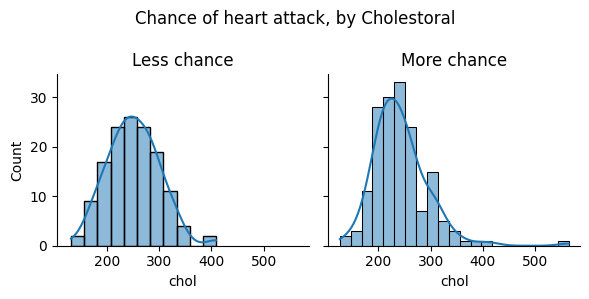

In [21]:
# Total Cholestoral distribution
g = sns.displot(df.chol, kde=True)
g.figure.suptitle("Total Cholestoral Distribution")

g2 = sns.FacetGrid(df, col=TARGET)

# mapping of target attribute's values
axes = g2.axes.flatten()
axes[HeartAttack.NotLikely.value].set_title("Less chance")
axes[HeartAttack.Likely.value].set_title("More chance")

g2.figure.suptitle("Chance of heart attack, by Cholestoral") # Set global title

g2.map(sns.histplot, "chol", kde=True)

<a name="total-maxium-heart-rate-achieved-thalachh"></a>
### Total Maxium Heart Rate Achieved (`thalachh`)

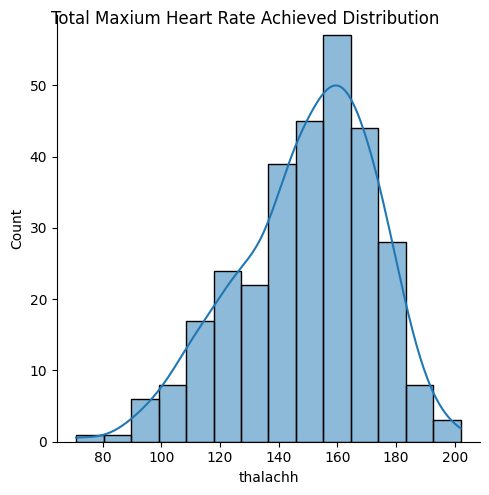

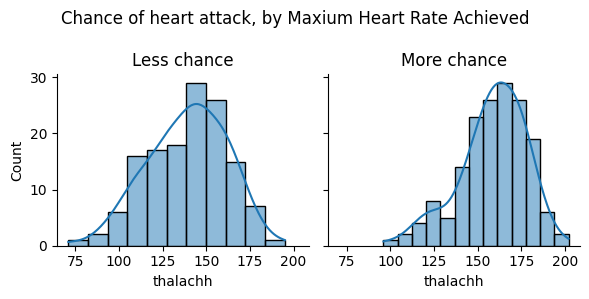

In [22]:
# Total Maxium Heart Rate Achieved distribution
g = sns.displot(df.thalachh, kde=True)
g.figure.suptitle("Total Maxium Heart Rate Achieved Distribution")

g2 = sns.FacetGrid(df, col=TARGET)

# mapping of target attribute's values
axes = g2.axes.flatten()
axes[HeartAttack.NotLikely.value].set_title("Less chance")
axes[HeartAttack.Likely.value].set_title("More chance")

g2.figure.suptitle("Chance of heart attack, by Maxium Heart Rate Achieved") # Set global title

g2.map(sns.histplot, "thalachh", kde=True)

---

<a name="prediction"></a>
## Prediction

Since the target attribute (HeartAttack) is a boolean (More or Less chance), we are dealing with a **binary classification** problem.

<a name="pre-processing"></a>
### Pre-processing

<a name="split-the-dataset-into-training-and-testing-sets"></a>
#### Split the dataset into training and testing sets

In [23]:
X = df[FEATURES]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

<a name="upsampling--balancing"></a>
#### Upsampling / Balancing

The distribution of the `target` attribute in the dataset is rather **well balanced**. Therefore, there is no need to upsample the dataset.

<a name="transformation-pipeline"></a>
#### Transformation Pipeline

In [24]:
# Preprocessing pipeline for CONTINUOUS variables
preprocessor_con = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])

# Preprocessing pipeline for CATEGORICAL variables
preprocessor_cat = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine the 2 preprocessing pipelines into one
preprocessor = ColumnTransformer([
    ('num', preprocessor_con, CONTINUOUS),
    ('cat', preprocessor_cat, CATEGORICAL)
])

- Certain numerical/continuous attributes in the dataset have **different scaling** (for example, `age`, `chol` and `oldpeak`). Therefore, I am using a scaling technique (`StandardScaler`) for continuous variables in order to improve efficiency of the distance based algorithms (like KNN and SVM)

- The imputers (`SimpleImputer`) in both transformation pipelines are **optional**, because the dataset **does not contain any null values**.

- Categorical attributes in the dataset are **already encoded** into integers. Thus, the encoder (`OneHotEncoder`) is **optional** in the categorical transformation pipeline.

> Note: The dataset was already well structured, but in other scenario we would use all of the above techniques to preprocess the data for the efficiency of the learning algorithms.

<a name="naive-approach"></a>
### Naive Approach

Trying the Linear Regression classifier **without** preprocessing and X-validation.

In [25]:
# Trying the Linear Regression classifier
clf = LinearRegression()

clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# MAE (Mean Absolute Error)
print('MAE on train data:        ', mean_absolute_error(y_train, predict_train))
print('MAE on test data:         ', mean_absolute_error(y_test, predict_test), '\n')

# MSE (Mean Squared Error)
print('MSE on train data:        ', mean_squared_error(y_train, predict_train))
print('MSE on test data:         ', mean_squared_error(y_test, predict_test), '\n')

# RMSE (Root Mean Squared Error)
print('RMSE on train data:       ', mean_squared_error(y_train, predict_train) ** 0.5)
print('RMSE on test data:        ', mean_squared_error(y_test, predict_test) ** 0.5, '\n')

# R Squared
print('R Squared on train data:  ', r2_score(y_train, predict_train))
print('R Squared on test data:   ', r2_score(y_test, predict_test))

MAE on train data:         0.2685666543259952
MAE on test data:          0.30808196698105694 

MSE on train data:         0.11354585079633552
MSE on test data:          0.15073579700959824 

RMSE on train data:        0.3369656522501003
RMSE on test data:         0.388247082422519 

R Squared on train data:   0.542518626787046
R Squared on test data:    0.3911009097383009


<a name="model-selection"></a>
### Model Selection

<a name="try-different-classifiers-and-compare-the-results"></a>
#### Try different classifiers and compare the results.

In [26]:
# Declare classifiers to try
classifiers = {
    'Logistic Regression':  LogisticRegression(),
    'Decision Tree':        DecisionTreeClassifier(criterion='gini', max_depth=10),
    'Random Forest':        RandomForestClassifier(random_state=SEED),
    'SVM':                  SVC(random_state=SEED)
}

# Main ML pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier',   None) # placeholder for the classifiers
])

clf_perfs = []

# Predict using each classifier with X-Validation
for key, val in classifiers.items():

    pipeline.set_params(classifier=val)
    predictions = cross_val_predict(
        pipeline,
        X_train, y_train,
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
        n_jobs = -1
    )

    print(key)
    print(classification_report(y_train, predictions, target_names=['Not Likely', 'Likely'], digits=3))

    accuracy = accuracy_score(y_train, predictions)
    metrics = precision_recall_fscore_support(y_train, predictions, average='macro')
    clf_perfs.append((accuracy, *metrics))

col_clf_perfs = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Support']
idx_clf_perfs = classifiers.keys()

df_clf_perfs = pd.DataFrame(data=clf_perfs, columns=col_clf_perfs, index=idx_clf_perfs)

print('Overall scores (with "macro" average):')
df_clf_perfs.drop(columns='Support')

Logistic Regression
              precision    recall  f1-score   support

  Not Likely      0.842     0.825     0.833        97
      Likely      0.855     0.870     0.862       115

    accuracy                          0.849       212
   macro avg      0.848     0.847     0.848       212
weighted avg      0.849     0.849     0.849       212

Decision Tree
              precision    recall  f1-score   support

  Not Likely      0.713     0.742     0.727        97
      Likely      0.775     0.748     0.761       115

    accuracy                          0.745       212
   macro avg      0.744     0.745     0.744       212
weighted avg      0.746     0.745     0.746       212

Random Forest
              precision    recall  f1-score   support

  Not Likely      0.777     0.825     0.800        97
      Likely      0.844     0.800     0.821       115

    accuracy                          0.811       212
   macro avg      0.810     0.812     0.811       212
weighted avg      0.813   

,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.849057,0.848403,0.847154,0.847701
Decision Tree,0.745283,0.743823,0.745047,0.744167
Random Forest,0.811321,0.810368,0.812371,0.810714
SVM,0.825472,0.824107,0.825415,0.824594


<a name="results"></a>
##### **Results**

Detailed and overall scores are displayed.  
After comparing the models, we can state that:
- The **most efficient** classifier is `Logistic Regression`; and
- The **least efficient** one is regular `Decision Tree`

<br/>

> Note: The distribution of the `target` attribute in the dataset is **well balanced**. Thus, we do not observe a big difference between the `precision`, the `recall` and, hence, their harmonic mean `F1` score. 

<a name="hyperparameter-optimization--tuning"></a>
### Hyperparameter optimization / tuning

<a name="model-evaluation"></a>
### Model Evaluation